In [1]:
from pathlib import Path
import copy
from tqdm import tqdm 

import torch
import pyscf
import numpy as np
import opt_einsum as oe

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol


/home/dhem/anaconda3/envs/pyscf/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
molecular = copy.deepcopy(Mol["Methane"])
molecular[0][1] += 0.0

dft2cc = CC_DFT_DATA(
    molecular,
    name="test",
    basis="cc-pvdz",
    if_basis_str=True,
)

mf = pyscf.scf.RHF(dft2cc.mol)
mf.kernel()
mycc = pyscf.cc.CCSD(mf)
mycc.kernel()
dm1_cc = mycc.make_rdm1(ao_repr=True)
dm2_cc = mycc.make_rdm2(ao_repr=True)
e_cc = mycc.e_tot

mdft = pyscf.scf.RKS(dft2cc.mol)
mdft.xc = "b3lyp"
mdft.kernel()
e_dft = mdft.e_tot
dm1_dft = mdft.make_rdm1(ao_repr=True)

grids = Grid(dft2cc.mol)
coords = grids.coords
weights = grids.weights
ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
ao_0 = ao_2[0, :, :]
ao_value = ao_2[:4, :, :]
ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

In [114]:
471.8*2

943.6

In [14]:
x_grids = grids.vector_to_matrix(coords[:,0])[0, -1, :] - molecular[0][1]
y_grids = grids.vector_to_matrix(coords[:,1])[0, -1, :] - molecular[0][2]
z_grids = grids.vector_to_matrix(coords[:,2])[0, -1, :] - molecular[0][3]

In [115]:
argsort_list = []

argsort_list.append(np.where((x_grids >= 0) & (y_grids >= 0) & (z_grids >= 0))[0])
argsort_list.append(np.where((x_grids <= 0) & (y_grids >= 0) & (z_grids >= 0))[0])
argsort_list.append(np.where((x_grids >= 0) & (y_grids <= 0) & (z_grids >= 0))[0])
argsort_list.append(np.where((x_grids <= 0) & (y_grids <= 0) & (z_grids >= 0))[0])
argsort_list.append(np.where((x_grids >= 0) & (y_grids >= 0) & (z_grids <= 0))[0])
argsort_list.append(np.where((x_grids <= 0) & (y_grids >= 0) & (z_grids <= 0))[0])
argsort_list.append(np.where((x_grids >= 0) & (y_grids <= 0) & (z_grids <= 0))[0])
argsort_list.append(np.where((x_grids <= 0) & (y_grids <= 0) & (z_grids <= 0))[0])

print(np.array(argsort_list))

[[  0   2   4   6  14  22  30  38  46  54  62  70  78  86  94 102 110 118
  126 134 142 150 158 162 166 170 174 178 182 186 190 194 198 202 206 214
  222 230 238 246 254 262 270 278 286 294]
 [  1   2   4   7  15  23  31  39  47  55  63  71  79  87  95 103 111 119
  127 135 143 151 159 163 167 171 174 178 183 187 191 195 198 202 207 215
  223 231 239 247 255 263 271 279 287 295]
 [  0   3   4   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120
  128 136 144 152 160 164 166 170 175 179 184 188 190 194 199 203 208 216
  224 232 240 248 256 264 272 280 288 296]
 [  1   3   4   9  17  25  33  41  49  57  65  73  81  89  97 105 113 121
  129 137 145 153 161 165 167 171 175 179 185 189 191 195 199 203 209 217
  225 233 241 249 257 265 273 281 289 297]
 [  0   2   5  10  18  26  34  42  50  58  66  74  82  90  98 106 114 122
  130 138 146 154 158 162 168 172 176 180 182 186 192 196 200 204 210 218
  226 234 242 250 258 266 274 282 290 298]
 [  1   2   5  11  19  27  35  43  51  59  67

46
46
46
46
46
46
46
46
368


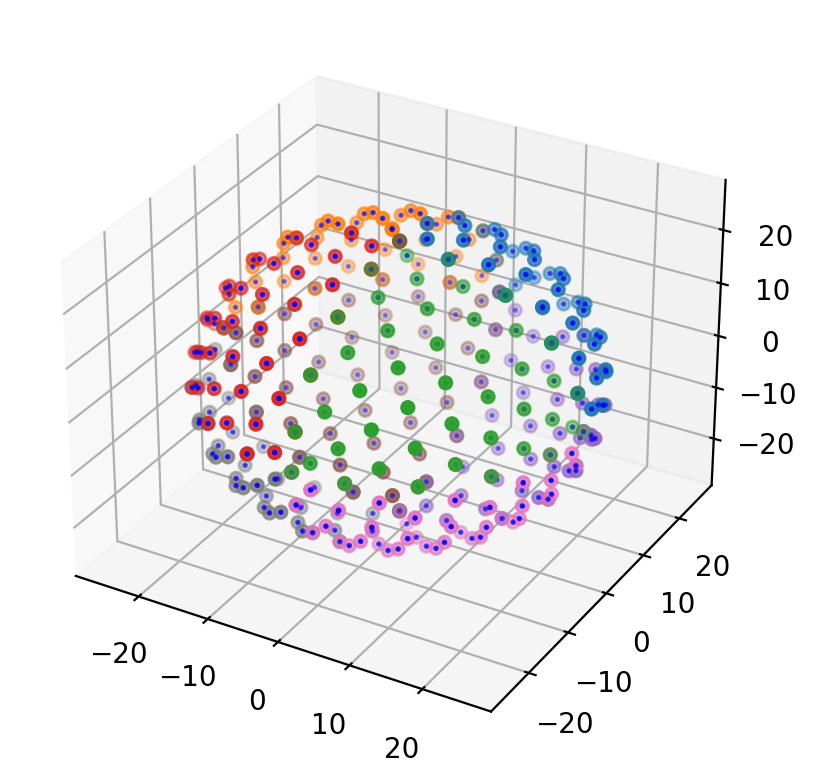

In [113]:
# plot 3d
import matplotlib.pyplot as plt

index_sum = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_grids, y_grids, z_grids, c='b', s=1)
for argsort_i in argsort_list:
    print(len(argsort_i))
    index_sum += len(argsort_i)
    ax.scatter(x_grids[argsort_i], y_grids[argsort_i], z_grids[argsort_i])
print(index_sum)

In [125]:
weight_ = np.zeros_like(x_grids)
weight_list = np.zeros_like(argsort_list)

for argsort_i in argsort_list:
    weight_[argsort_i] += 1

for i in range(weight_list.shape[0]):
    weight_list[i] = weight_[argsort_list[i]]

np.save("weight_list.npy", weight_list)
np.save("argsort_list.npy", argsort_list)

[  0   2   4   6  14  22  30  38  46  54  62  70  78  86  94 102 110 118
 126 134 142 150 158 162 166 170 174 178 182 186 190 194 198 202 206 214
 222 230 238 246 254 262 270 278 286 294] [4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[  1   2   4   7  15  23  31  39  47  55  63  71  79  87  95 103 111 119
 127 135 143 151 159 163 167 171 174 178 183 187 191 195 198 202 207 215
 223 231 239 247 255 263 271 279 287 295] [4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[  0   3   4   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120
 128 136 144 152 160 164 166 170 175 179 184 188 190 194 199 203 208 216
 224 232 240 248 256 264 272 280 288 296] [4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[  1   3   4 

In [ ]:
rho_dft_grids_list = 

In [3]:
# exc_over_dm_cc_grids = np.zeros_like(rho_dft[0])
# exc_over_dm_cc_grids = -pyscf.dft.libxc.eval_xc("b3lyp", rho_dft)[0] * rho_dft[0]
# expr_rinv_dm2_r = oe.contract_expression(
#     "ijkl,i,j,kl->",
#     0.5 * (dm2_cc - oe.contract("pq,rs->pqrs", dm1_dft, dm1_dft))
#     + 0.05 * oe.contract("pr,qs->pqrs", dm1_dft, dm1_dft),
#     (dft2cc.mol.nao,),
#     (dft2cc.mol.nao,),
#     (dft2cc.mol.nao, dft2cc.mol.nao),
#     constants=[0],
#     optimize="optimal",
# )

# for i, coord in enumerate(tqdm(coords)):
#     ao_0_i = ao_value[0][i]
#     if np.linalg.norm(ao_0_i) < 1e-10:
#         continue
#     with dft2cc.mol.with_rinv_origin(coord):
#         rinv = dft2cc.mol.intor("int1e_rinv")
#         exc_over_dm_cc_grids[i] += expr_rinv_dm2_r(ao_0_i, ao_0_i, rinv)

#     for i_atom in range(dft2cc.mol.natm):
#         exc_over_dm_cc_grids[i] -= (
#             (rho_cc[0][i] - rho_dft[0][i])
#             * dft2cc.mol.atom_charges()[i_atom]
#             / np.linalg.norm(dft2cc.mol.atom_coords()[i_atom] - coord)
#         )

# dm1_cc_mo = mycc.make_rdm1(ao_repr=False)
# eigs_e_dm1, eigs_v_dm1 = np.linalg.eigh(dm1_cc_mo)
# eigs_v_dm1 = mf.mo_coeff @ eigs_v_dm1
# for i in range(np.shape(eigs_v_dm1)[1]):
#     part = oe.contract(
#         "pm,m,n,pn->p",
#         ao_0,
#         eigs_v_dm1[:, i],
#         eigs_v_dm1[:, i],
#         ao_2_diag,
#     )
#     exc_over_dm_cc_grids += -part * eigs_e_dm1[i] / 2

# for i in range(dft2cc.mol.nelec[0]):
#     part = oe.contract(
#         "pm,m,n,pn->p",
#         ao_0,
#         mdft.mo_coeff[:, i],
#         mdft.mo_coeff[:, i],
#         ao_2_diag,
#     )
#     exc_over_dm_cc_grids += part

# error = np.sum(exc_over_dm_cc_grids * weights) - (e_cc - e_dft)

# print(f"Error: {(1e3 * error):.5f} mHa")

In [4]:
# ene_cc_grids = grids.vector_to_matrix(exc_over_dm_cc_grids)
rho_cc_grids_pred = np.zeros_like(rho_cc_grids)
ene_cc_grids_pred = np.zeros_like(rho_cc_grids)

In [5]:
from cadft.utils import ModelDict

Modeldict = ModelDict(302, 3, 1, "cuda", if_mkdir=False)
Modeldict.load_model("2024-06-07-12-53-06")

Model loaded from checkpoints/checkpoint-ccdft-2024-06-07-12-53-06-302/1-2500.pth
Model loaded from checkpoints/checkpoint-ccdft-2024-06-07-12-53-06-302/2-2500.pth


In [23]:
weight = grids.vector_to_matrix(weights)

for i_atom in range(weight.shape[0]):
    input_i = rho_dft_grids[i_atom, 6:-5, :][np.newaxis, np.newaxis, :, :]
    input_gpu = torch.tensor(input_i, dtype=torch.float64).to("cuda")
    output_ = Modeldict.model_dict["1"](input_gpu).detach().cpu().numpy()
    # print(output_)
    rho_cc_grids_pred[i_atom, 6:-5, :] = np.squeeze(output_ / 1000 + input_i, axis=1)
    output_ = Modeldict.model_dict["2"](input_gpu).detach().cpu().numpy()
    ene_cc_grids_pred[i_atom, 6:-5, :] = np.squeeze(output_ / 1000, axis=1)

print(
    (np.sum(grids.matrix_to_vector(ene_cc_grids_pred) * weights) - (e_cc - e_dft))
    * 1000
)
# print(ene_)

9641.386299928408


In [21]:
print(
    np.sum(
        np.abs(
            grids.matrix_to_vector(ene_cc_grids_pred) * weights
            - grids.matrix_to_vector(ene_cc_grids) * weights
        )
    )
)

print(np.sum(np.abs(grids.matrix_to_vector(ene_cc_grids) * weights)))

print(
    np.sum(
        grids.matrix_to_vector(ene_cc_grids_pred) * weights
        - grids.matrix_to_vector(ene_cc_grids) * weights
    )
)

0.4449777562211158
0.36705452042958275
0.030328315413492988


(-2.5, 2.5)

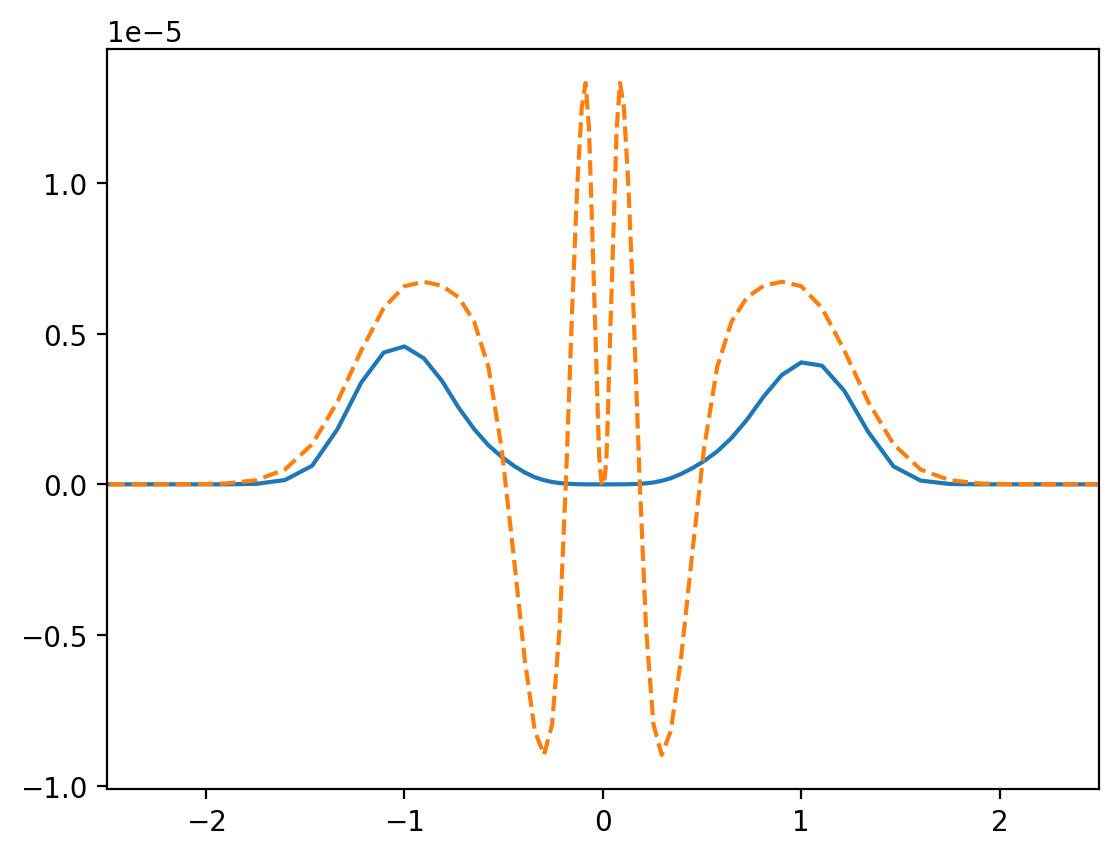

In [22]:
index_ = np.where((np.abs(coords[:, 1]) < 1e-14) & (np.abs(coords[:, 2]) < 1e-14))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y1 = (grids.matrix_to_vector(ene_cc_grids_pred) * weights)[index_][sort_]
y2 = (grids.matrix_to_vector(ene_cc_grids) * weights)[index_][sort_]

plt.plot(x, y1, label="Predicted")
plt.plot(x, y2, label="Exact", linestyle="--")
plt.xlim(-2.5, 2.5)

In [10]:
x = grids.vector_to_matrix(grids.coords[:, 0])[0, 0, :]
y = grids.vector_to_matrix(grids.coords[:, 1])[0, 0, :]
z = grids.vector_to_matrix(grids.coords[:, 2])[0, 0, :]

z.shape

(302,)

In [26]:
# print(
#     np.sum((grids.matrix_to_vector(rho_cc_grids_pred - rho_cc_grids) * weights))
# )
# print(np.sum((grids.matrix_to_vector(rho_dft_grids - rho_cc_grids) * weights)))

print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))))

index_1 = np.mean(np.abs(rho_cc_grids), axis=-1) > 1e-5
index_2 = np.mean(np.abs(rho_cc_grids * grids.vector_to_matrix(weights)), axis=-1)> 1e-8
index_ = np.logical_not(index_1 & index_2)
print(np.where(index_))
print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))[index_]))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))[index_]))

index_ = index_1 & index_2
print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))[index_]))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))[index_]))
# print(np.sum((grids.matrix_to_vector(rho_dft_grids - rho_cc_grids) * weights)))

9.999999596299151
0.1479665564661628
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]), array([ 0,  1,  2,  3,  4,  5,  6,  7, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 62, 63, 64,
      

In [81]:
ene_cc_grids[:,6:-5,:].shape
np.array(range(20)), np.array(range(20))[6:-5]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14]))

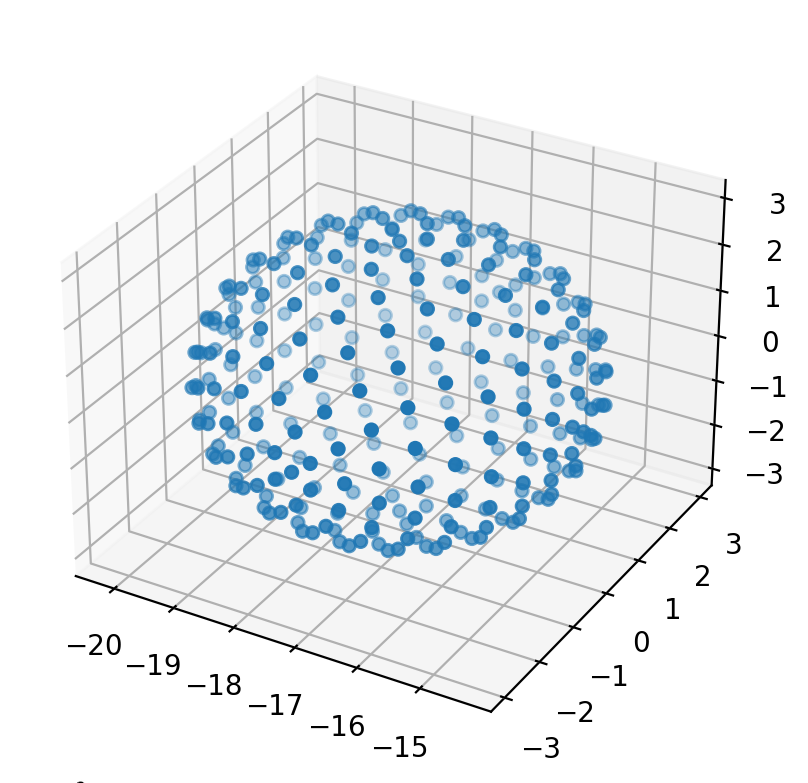

In [20]:
# polt x, y, z
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z)